In [44]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple
import os

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [3]:
def get_co2_multiplier(name):
    match = re.match(r'co2_([\d_]+)x', name)
    if match:
        # Replace underscore with decimal point and convert to float
        return float(match.group(1).replace('_', '.'))
    elif name == 'pre_industrial':
        return 1  # for pre_industrial or other defaults
    else:
        raise ValueError(f'Not valid name = {name}')

In [23]:
data_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/3_hour/hottest_time'
exp_name = ['pre_industrial', 'co2_2x']
co2_vals = [1, 2]
n_exp = len(exp_name)
ds = [xr.load_dataset(os.path.join(data_dir, exp_name[i], 'output.nc')) for i in range(n_exp)]
ds = xr.concat(ds, dim=xr.DataArray(co2_vals, dims="co2", coords={"exp_name": ("co2", exp_name)}))

In [24]:
# Land masks
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
lsm = (xr.open_dataset(invariant_data_path).LANDFRAC > 0)
lsm = lsm.reindex_like(ds, method="nearest", tolerance=0.01)
ds['ZREFHT'] = cesm.load.load_z2m(invariant_data_path, var_reindex_like=ds.PS)

In [25]:
p_ft = 300 * 100
ds['P'] = cesm.get_pressure(ds.PS, ds.P0.isel(co2=0), ds.hyam.isel(co2=0), ds.hybm.isel(co2=0))
ds['T500'] = interp_hybrid_to_pressure(ds.T, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), ds.P0.isel(co2=0),
                                       np.atleast_1d(p_ft)).load()
ds['Z500'] = interp_hybrid_to_pressure(ds.Z3, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), ds.P0.isel(co2=0),
                                       np.atleast_1d(p_ft)).load()
ds['TREFHT'] = ds.T.isel(lev=-1)
ds['QREFHT'] = ds.Q.isel(lev=-1)
ds['ZREFHT'] = ds.Z3.isel(lev=-1)
ds['PREFHT'] = ds.P.isel(lev=-1)

In [27]:
# Only include Daily average contribution if using 500hPa pressure level
ds['T500_zonal_daily_av_resize'] = ds.T500_zonal_daily_av.where(ds.time_max.dt.floor('D') == ds.time.dt.floor('D')).max(
    dim='time')
if p_ft != 500 * 100:
    ds['T500_zonal_daily_av_resize'] = ds['T500_zonal_daily_av_resize'] * 0
    ds['T500_zonal_daily_av'] = ds['T500_zonal_daily_av'] * 0

## LCL
Compare physical LCL to empirical LCL found by requiring error to dry profile less than threshold.

In [29]:
# Physical from lowest model level
ds['p_lcl'], ds['T_lcl'] = lcl_metpy(ds.T.isel(lev=-1), ds.Q.isel(lev=-1), ds.P.isel(lev=-1))

In [30]:
def find_lcl_empirical(temp_env, p_env, temp_start=None, p_start=None, temp_thresh=0.5):
    # Find LCL as the lowest pressure level where the deviation between environmental and dry profile is less than a threshold
    if temp_start is None:
        temp_start = temp_env.isel(lev=-1)
    if p_start is None:
        p_start = p_env.isel(lev=-1)
    mask = np.abs(temp_env - dry_profile_temp(temp_start, p_start, p_env)) > temp_thresh
    # Find highest pressure where deviation between t_env and t_dry is more than threshold. Then go to next highest pressure as LCL
    lcl_ind = ((mask.where(mask, other=np.nan) * np.arange(ds.lev.size)).max(dim='lev') + 1).astype(int)
    return p_env.isel(lev=lcl_ind), temp_env.isel(lev=lcl_ind)


ds['p_lcl_emp'], ds['T_at_lcl_emp'] = find_lcl_empirical(ds.T, ds.P)

In [31]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180, 180.01, 60), grid_lat=np.asarray([-30, 30])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels = 0
    gl.top_labels = 0
    return ax


def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=lsm, cmap='viridis'):
    data, lon = add_cyclic_point(var if mask is None else var.where(mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

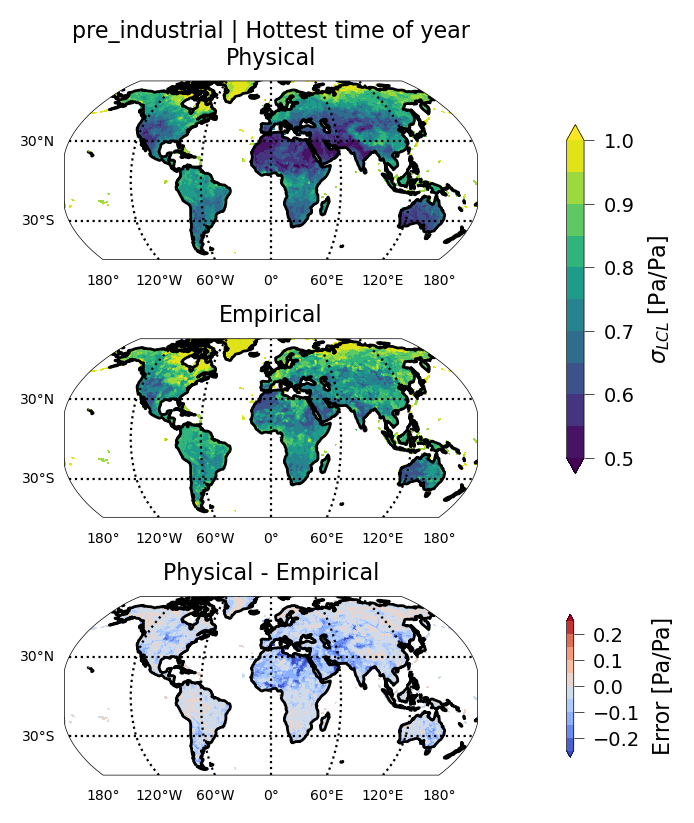

In [33]:
lat_plot_min = -60
lat_plot_max = 80

co2_ind = 0
fig = plt.figure(constrained_layout=True, figsize=(10., 4))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max)

levels_use = np.arange(0.5, 1.05, 0.05)
plot_contour_projection(ax[0], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                        cmap='viridis', levels=levels_use)
im = plot_contour_projection(ax[1], (ds['p_lcl_emp'] / ds.P.isel(lev=-1)).isel(co2=co2_ind), cmap='viridis',
                             levels=levels_use)
fig.colorbar(shrink=0.8, ax=ax[:2], label='$\sigma_{LCL}$ [Pa/Pa]', mappable=im)
im = plot_contour_projection(ax[2], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind) - (
        ds['p_lcl_emp'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                             cmap='coolwarm', levels=np.arange(-0.25, 0.3, 0.05))

ax[0].set_title(f'{exp_name[co2_ind]} | Hottest time of year\nPhysical')
ax[1].set_title('Empirical')
ax[2].set_title('Physical - Empirical')
fig.colorbar(shrink=0.8, ax=ax[2], label='Error [Pa/Pa]', mappable=im)
# isca_tools.savefig(fig)
plt.show()

## Lapse Rate Error
Here, I compute the lapse rate between the LCL and 500hPa. Then I compute an error metric based on the individual lapse rates between model levels, and how these compare to the bulk lapse rate of the entire layer.

In [16]:
def rms_lapse_profile_1d(temp: np.ndarray, z: np.ndarray, p: np.ndarray, p_lcl: float,
                         t_upper: float,
                         z_upper: float,
                         gamma_ref: float,
                         p_upper: float = 500 * 100) -> Tuple[float, float, float, float]:
    """1D helper: RMS surface-proxy from one vertical profile."""

    # Mask between LCL and >upper limit
    if p_lcl < p_upper:
        return np.nan, np.nan, np.nan, np.nan
    mask = (p <= p_lcl) & (p > p_upper)
    temp_sel = temp[mask]
    z_sel = z[mask]
    p_sel = p[mask]

    # Append exact upper limit point
    temp_sel = np.concatenate([temp_sel, [t_upper]])
    z_sel = np.concatenate([z_sel, [z_upper]])
    p_sel = np.concatenate([p_sel, [p_upper]])

    # Sort descending p (surface to top)
    order = np.argsort(-p_sel)
    temp_sel = temp_sel[order]
    z_sel = z_sel[order]
    p_sel = p_sel[order]

    # Layerwise lapse rates
    dz = np.diff(z_sel)
    dT = np.diff(temp_sel)
    gamma = -dT / dz

    # Bulk lapse rate
    DeltaZ = np.abs(z_sel[0] - z_sel[-1])

    # Variance
    dev_sq = (gamma - gamma_ref) ** 2
    numerator = np.sum(dev_sq * dz)
    try:
        ind_max_error = np.argmax(dev_sq * dz)
    except ValueError as e:
        print(e)
        print(dz)
        print(p_sel)
        print(p_lcl)
    p_max_error = p_sel[ind_max_error]
    sigma_gamma = np.sqrt(numerator / DeltaZ)
    # print(np.sqrt((dev_sq * dz)[ind_max_error]))
    frac_max_error = np.sqrt((dev_sq * dz)[ind_max_error] / numerator)

    return sigma_gamma * 1000, DeltaZ, frac_max_error, p_max_error


def rms_lapse(ds: xr.Dataset) -> xr.DataArray:
    """Apply RMS lapse function across all points in dataset.

    ds must contain DataArrays:
      - temp(lev, ...) [K]
      - z(lev, ...)    [m]
      - p(lev, ...)    [Pa or hPa]
      - t500(...), z500(...), p_lcl(...), p_s(...)
    """
    out = xr.apply_ufunc(
        rms_lapse_profile_1d,
        ds.T,
        ds.Z3,
        ds.P,
        ds.p_lcl_emp + 1e-5,
        ds.T500,
        ds.Z500,
        ds.lapse_above_lcl / 1000,
        float(ds.plev),
        input_core_dims=[['lev'], ['lev'], ['lev'], [], [], [], [], []],
        output_core_dims=[[], [], [], []],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float, float, float, float],
    )
    # out.name = "RMS_T_surface_proxy"
    return out

In [36]:
ds['lapse_below_lcl'] = get_bulk_lapse_rate(ds.T.isel(lev=-1), ds.T_at_lcl_emp, ds.P.isel(lev=-1), ds.p_lcl_emp) * 1000
ds['lapse_below_lcl'] = ds['lapse_below_lcl'].fillna(
    lapse_dry * 1000)  # the regions where p_lcl = lowest model level, set to dry value

ds['lapse_above_lcl'] = get_bulk_lapse_rate(ds.T_at_lcl_emp, ds.T500, ds.p_lcl_emp, float(ds.plev)) * 1000

ds['lapse_above_lcl_error'], ds['lapse_above_lcl_zrange'], ds['lapse_above_lcl_error_frac'], ds[
    'lapse_above_lcl_error_p'] = rms_lapse(ds)

## Theoretical Temperature Decomposition
Decompose surface temperature into contributions from LCL height, lapse rates either side, and $T_{500}$.

In [38]:
def get_var_av(var, n_lat_av=30, mask=lsm):
    n_pad = n_lat_av // 2  # half window size
    # Pad edge with same values so can take average over latitude
    var_padded = var.where(mask).mean(dim="lon").pad(lat=(n_pad, n_pad), mode="edge")
    var_av = (var_padded.rolling(lat=n_lat_av, center=True).mean(dim="lat"))
    var_av = var_av.isel(lat=slice(n_pad, -n_pad))  # only return latitudes kept all along
    return var_av

In [39]:
mask_use = lsm.where(ds.p_lcl_emp > 550 * 100) > 0
ds['sigma_lcl_emp'] = ds['p_lcl_emp'] / ds.PREFHT
ds['sigma500'] = float(ds.plev) / ds['PREFHT']
ds['T500_zonal_daily_anom'] = ds.T500 - ds.T500_zonal_daily_av_resize
T_breakdown_av = {var: get_var_av(ds[var], mask=mask_use) for var in
                  ['T500_zonal_daily_av_resize', 'T500_zonal_daily_anom', 'p_lcl_emp', 'lapse_above_lcl',
                   'lapse_below_lcl', 'PREFHT', 'sigma_lcl_emp', 'sigma500']}
T_breakdown_av['T500'] = T_breakdown_av['T500_zonal_daily_av_resize'] + T_breakdown_av['T500_zonal_daily_anom']
# Compute average temperature from all the other average variables
T_breakdown_av['TREFHT'] = reconstruct_temp(T_breakdown_av['T500'], T_breakdown_av['PREFHT'],
                                            T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['PREFHT'], float(ds.plev),
                                            T_breakdown_av['lapse_below_lcl'] / 1000,
                                            T_breakdown_av['lapse_above_lcl'] / 1000)

T_breakdown_anom = {var: ds[var] - T_breakdown_av[var] for var in T_breakdown_av}

T_breakdown_cont = {}
T_breakdown_cont['T500_zonal_daily_av_resize'] = reconstruct_temp(
    T_breakdown_av['T500'] + T_breakdown_anom['T500_zonal_daily_av_resize'],
    T_breakdown_av['PREFHT'],
    T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['PREFHT'], float(ds.plev),
    T_breakdown_av['lapse_below_lcl'] / 1000,
    T_breakdown_av['lapse_above_lcl'] / 1000) - T_breakdown_av['TREFHT']

T_breakdown_cont['T500_zonal_daily_anom'] = reconstruct_temp(
    T_breakdown_av['T500'] + T_breakdown_anom['T500_zonal_daily_anom'],
    T_breakdown_av['PREFHT'],
    T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['PREFHT'], float(ds.plev),
    T_breakdown_av['lapse_below_lcl'] / 1000,
    T_breakdown_av['lapse_above_lcl'] / 1000) - T_breakdown_av['TREFHT']

T_breakdown_cont['sigma_lcl_emp'] = reconstruct_temp(
    T_breakdown_av['T500'],
    T_breakdown_av['PREFHT'],
    (T_breakdown_av['sigma_lcl_emp'] + T_breakdown_anom['sigma_lcl_emp']) * T_breakdown_av['PREFHT'], float(ds.plev),
    T_breakdown_av['lapse_below_lcl'] / 1000,
    T_breakdown_av['lapse_above_lcl'] / 1000) - T_breakdown_av['TREFHT']

T_breakdown_cont['sigma500'] = reconstruct_temp(
    T_breakdown_av['T500'],
    T_breakdown_av['PREFHT'] + T_breakdown_anom['PREFHT'],
    T_breakdown_av['sigma_lcl_emp'] * (T_breakdown_av['PREFHT'] + T_breakdown_anom['PREFHT']), float(ds.plev),
    T_breakdown_av['lapse_below_lcl'] / 1000,
    T_breakdown_av['lapse_above_lcl'] / 1000) - T_breakdown_av['TREFHT']

T_breakdown_cont['lapse_below_lcl'] = reconstruct_temp(
    T_breakdown_av['T500'],
    T_breakdown_av['PREFHT'],
    T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['PREFHT'], float(ds.plev),
    (T_breakdown_av['lapse_below_lcl'] + T_breakdown_anom['lapse_below_lcl']) / 1000,
    T_breakdown_av['lapse_above_lcl'] / 1000) - T_breakdown_av['TREFHT']

T_breakdown_cont['lapse_above_lcl'] = reconstruct_temp(
    T_breakdown_av['T500'],
    T_breakdown_av['PREFHT'],
    T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['PREFHT'], float(ds.plev),
    T_breakdown_av['lapse_below_lcl'] / 1000,
    (T_breakdown_av['lapse_above_lcl'] + T_breakdown_anom['lapse_above_lcl']) / 1000) - T_breakdown_av['TREFHT']


# T_breakdown_sensitivity = {'T500_zonal_daily_av_resize': T_breakdown_av['TREFHT'] / T_breakdown_av['T500'],
#                            'T500_zonal_daily_anom': T_breakdown_av['TREFHT'] / T_breakdown_av['T500'],
#                            'lapse_below_lcl': -(T_breakdown_av['TREFHT'] * np.log(T_breakdown_av['sigma_lcl_emp'])) * R / g / 1000,
#                            'lapse_above_lcl': (T_breakdown_av['TREFHT'] * np.log(T_breakdown_av['sigma_lcl_emp'])) * R / g / 1000,
#                            'sigma_lcl_emp': R / g * ((T_breakdown_av['lapse_above_lcl'] - T_breakdown_av['lapse_below_lcl']) / 1000 / T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['TREFHT']),
#                            'sigma500': -R / g * (T_breakdown_av['lapse_above_lcl'] / 1000 / T_breakdown_av['sigma500'] * T_breakdown_av['TREFHT'])}
#
#
# T_breakdown_cont = {key: T_breakdown_anom[key] * T_breakdown_sensitivity[key]
#                               for key in T_breakdown_sensitivity}
T_anom_theory = sum(T_breakdown_cont.values()).isel(plev=0)
# T_anom_theory = sum(T_breakdown_cont.values()).isel(plev=0)

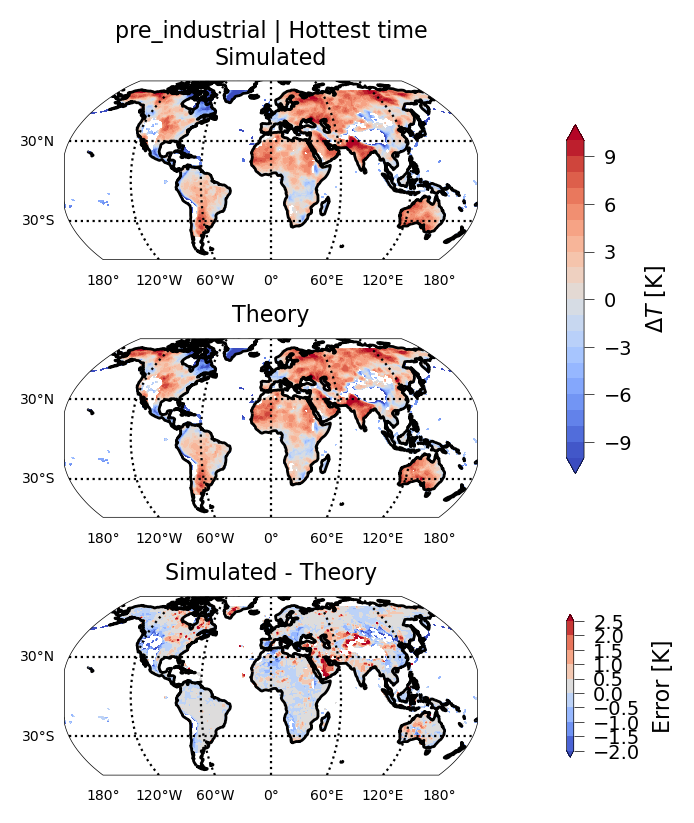

In [41]:
lat_plot_min = -60
lat_plot_max = 80
# norm_by_av = 'FT'
co2_ind = 0
fig = plt.figure(constrained_layout=True, figsize=(10., 4))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max)

levels_use = np.arange(-10, 11, 1)
plot_contour_projection(ax[0], T_breakdown_anom['TREFHT'].isel(co2=co2_ind, plev=0),
                        cmap='coolwarm', levels=levels_use, mask=mask_use.isel(co2=co2_ind))
im = plot_contour_projection(ax[1], T_anom_theory.isel(co2=co2_ind), cmap='coolwarm', levels=levels_use,
                             mask=mask_use.isel(co2=co2_ind))
fig.colorbar(shrink=0.8, ax=ax[:2], label='$\Delta T$ [K]', mappable=im)
im = plot_contour_projection(ax[2],
                             T_breakdown_anom['TREFHT'].isel(co2=co2_ind, plev=0) - T_anom_theory.isel(co2=co2_ind),
                             cmap='coolwarm', levels=np.arange(-2, 3, 0.5), mask=mask_use.isel(co2=co2_ind))
# # im = plot_contour_projection(ax[1], var_theory,
# #                              levels=levels_temp_change[norm_by_av],
# #                              cmap='coolwarm' if norm_by_av else 'viridis')
ax[0].set_title(f'{exp_name[co2_ind]} | Hottest time\nSimulated')
ax[1].set_title('Theory')
ax[2].set_title('Simulated - Theory')
fig.colorbar(shrink=0.8, ax=ax[2], label='Error [K]', mappable=im)
# isca_tools.savefig(fig)
plt.show()

### Contribution from each mechanism
Below, I look at the contribution from each mechanism in causing a region to be anomalously warm in a given climate compared to the spatial average.

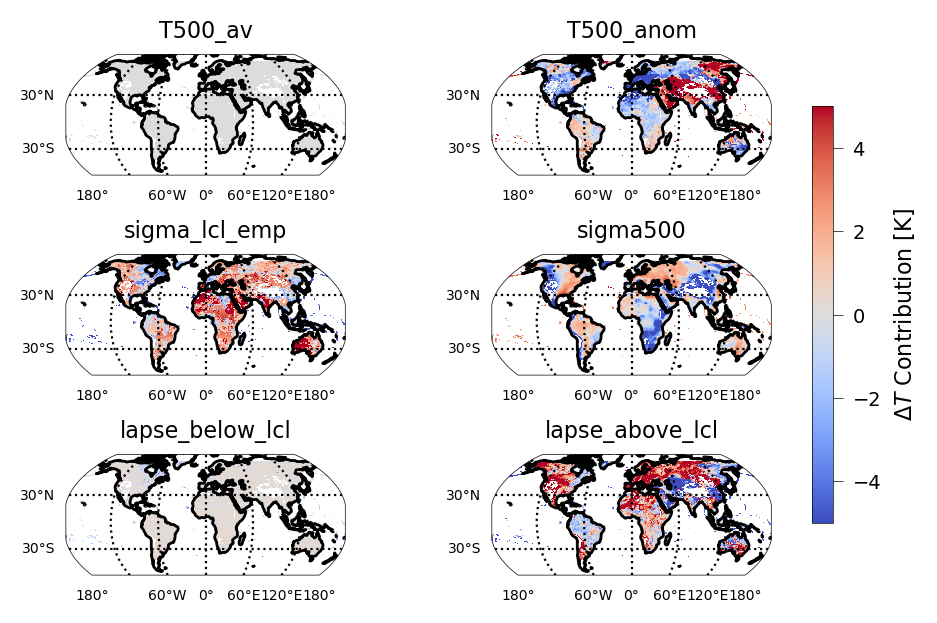

In [42]:
co2_ind=0
fig = plt.figure(constrained_layout=True,figsize=(10/2,6/2))
ax = fig.subplots(3,2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
ax = ax.flatten()
for i, key in enumerate(T_breakdown_cont):
    initialize_ax_projection(ax[i], lat_min=lat_plot_min, lat_max=lat_plot_max)
    im = ax[i].pcolormesh(ds.lon.values, ds.lat.values, T_breakdown_cont[key].isel(co2=co2_ind, plev=0).where(mask_use.isel(co2=co2_ind)),
                        transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-5, vmax=5)
    ax[i].set_title(key.replace('_zonal_daily', '').replace('_resize', ''))
    # im = plot_contour_projection(ax[i], TREFHT_anom_breakdown_cont[key].isel(co2=co2_ind),
    #                              cmap='coolwarm', levels=np.arange(-15, 20, 2.5))
#     fig.colorbar(shrink=0.8, ax=ax[i], label=f'{name_breakdown[key]} [K]', mappable=im)
fig.colorbar(shrink=0.8, ax=ax.ravel(), label=f'$\Delta T$ Contribution [K]', mappable=im)
# fig.suptitle(f'$\Delta T_{"{REFHT}"}$ Breakdown\n{exp_labels[co2_ind]} | $(x={quant[1]}) - (x={quant[0]})$')
# isca_tools.savefig(fig)
plt.show()

### $T_s$ error due to $\Gamma$ error
Below I compute the error in the surface temperature due to the variation in the lapse rate above the LCL i.e. due to fact it is not constant between LCL and 500hPa.

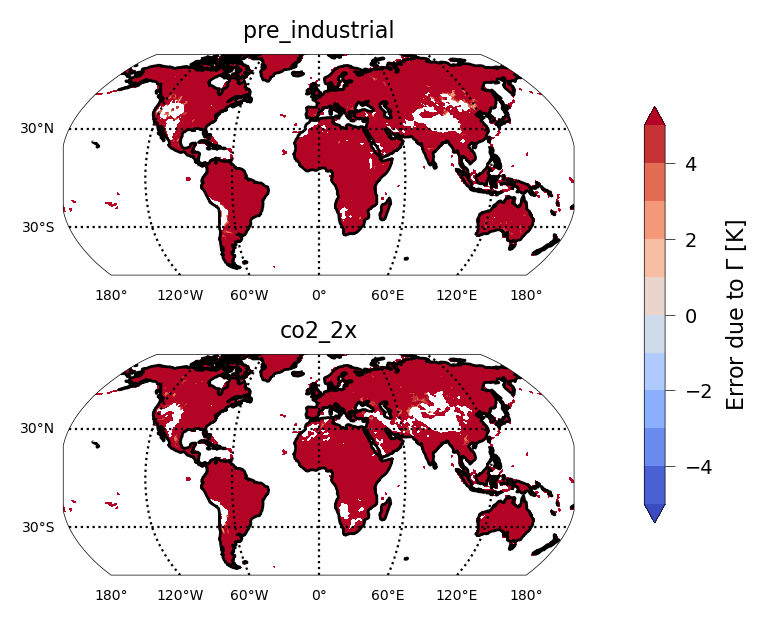

In [43]:
temp_error_lapse = ds['lapse_above_lcl_error'] * ds['lapse_above_lcl_zrange']/1000 * (ds.PREFHT/ds.p_lcl_emp)**(R*ds.lapse_below_lcl/1000/g)
lat_plot_min = -60
lat_plot_max = 80
levels_use = np.arange(-5, 6, 1)
fig = plt.figure(constrained_layout=True, figsize=(8., 3))
ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)

for i in range(n_exp):
    im = plot_contour_projection(ax[i], temp_error_lapse.isel(co2=i, plev=0), cmap='coolwarm', levels=levels_use,
                                 mask=mask_use.isel(co2=i))
    ax[i].set_title(exp_name[i])
fig.colorbar(shrink=0.8, ax=ax.ravel(), label='Error due to $\Gamma$ [K]', mappable=im)
plt.show()

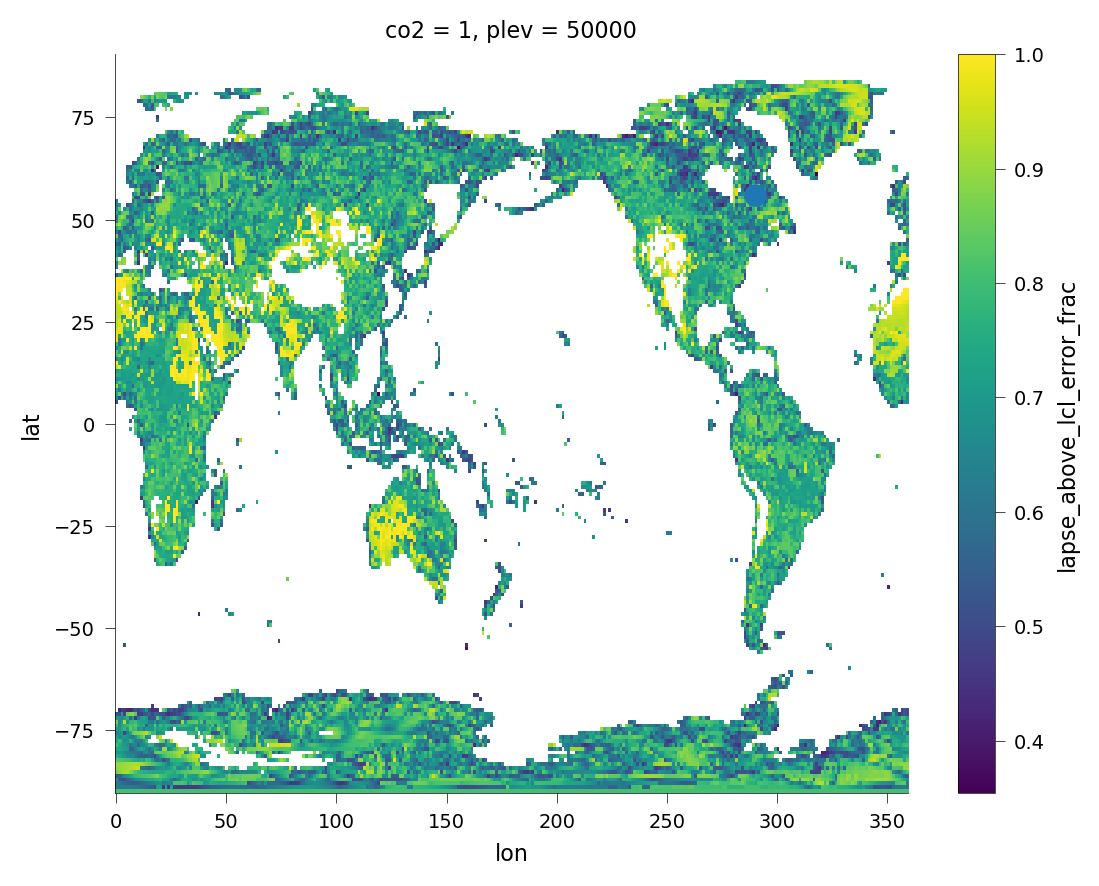

In [85]:
ds['lapse_above_lcl_error_frac'].isel(co2=0, plev=0).where(mask_use.isel(co2=0)).plot.imshow()
plt.scatter(290, 56, marker='o', s=50)

### Example temperature profiles in Z Space
Below I look at some regions, to look what the temperature profile looks like in T vs Z space. If constant lapse rate is good approximation, it should be obvious in this space.

In [138]:
def const_lapse_lcl_profile(temp_refht, p_refht, temp_at_lcl, p_at_lcl, lapse_below_lcl, lapse_above_lcl, p):
    temp_profile = reconstruct_temp(temp_at_lcl, p, p, p_at_lcl, lapse_above_lcl/1000, lapse_above_lcl/1000)
    temp_profile[p>=p_at_lcl] = reconstruct_temp(temp_refht, p[p>=p_at_lcl], p[p>=p_at_lcl], p_refht, lapse_below_lcl/1000, lapse_below_lcl/1000)
    return temp_profile

def apply_func_vec(func, p, *args):
    # Must p be the last argument of func. p is the pressure levels in Pa, where desire to get temperature
    return xr.apply_ufunc(func, *args, p, input_core_dims=[[]] * len(args) + [['lev']],
                          output_core_dims=[['lev']], vectorize=True, dask='parallelized', output_dtypes=[float])

In [175]:
def get_best_lev_split_prof(temp_refht, p_refht, temp_lev, p_lev, p_surface, lev_min_index, hyam, hybm, p0, plev_step=1000, error_mode='mean'):
    # Returns 2 lapse rate profile, choosing the splitting point to minimise the error
    if 'plev' in temp_lev.coords:
        temp_lev = temp_lev.drop('plev')
    if 'plev' in p_surface:
        p_surface = p_surface.drop('plev')
    plevs_split_all = np.arange(isca_tools.utils.base.round_any(float(p_lev.min()), plev_step, 'floor'),
                                isca_tools.utils.base.round_any(float(p_lev.max()), plev_step, 'ceil')+plev_step/2, plev_step)
    plevs_split_all = xr.DataArray(plevs_split_all, dims="p_split", name="p_split")
    temp_split_all = interp_hybrid_to_pressure(data=temp_lev, ps=p_surface, hyam=hyam, hybm=hybm, p0=p0,
                                               new_levels=plevs_split_all.values, lev_dim='lev')
    temp_split_all = temp_split_all.rename({'plev': 'p_split'})     # must match plevs_split dimension
    temp_split_all = temp_split_all.load()          # load all first to make quicker
    # temp_lev is temperature at each model level
    # error_mode is way to quantify error between actual profile and constant lapse profile across all levels
    lapse_below_all = get_bulk_lapse_rate(temp_refht, temp_split_all, p_refht,
                                          plevs_split_all.expand_dims({key: temp_refht[key] for key in temp_refht.dims})) * 1000
    # lapse_below_all = lapse_below_all * 0 + lapse_dry*1000
    lapse_above_all = get_bulk_lapse_rate(temp_split_all, temp_lev.isel(lev=lev_min_index),
                                          plevs_split_all.expand_dims({key: temp_refht[key] for key in temp_refht.dims}),
                                          p_lev.isel(lev=lev_min_index)) * 1000
    T_prof_all = []
    for j in range(plevs_split_all.size):
        T_prof_all.append(apply_func_vec(const_lapse_lcl_profile, p_lev, temp_refht, p_refht, temp_split_all.isel(p_split=j),
                                         plevs_split_all.isel(p_split=j), lapse_below_all.isel(p_split=j), lapse_above_all.isel(p_split=j)))
    T_prof_all = xr.concat(T_prof_all, dim=plevs_split_all)

    # Only include temperature up to LNB
    T_prof_all = T_prof_all.where(T_prof_all.p_split <= p_refht)        # Split level must be above REFHT
    T_prof_all = T_prof_all.where(T_prof_all.p_split >= p_lev.min(dim='lev'))    # Split level must be below min pressure
    T_prof_all = T_prof_all.where(T_prof_all.lev >= T_prof_all.lev.isel(lev=lev_min_index))

    # Find level which minimises error between actual profile and constant lapse profile
    prof_error = getattr(np.abs(temp_lev - T_prof_all), error_mode)(dim='lev', skipna=True).fillna(np.inf)
    ind_split_best = prof_error.argmin(dim='p_split').astype(int)
    # lev_split_best = argmin_with_nan
    temp_prof_best = T_prof_all.isel(p_split=ind_split_best, drop=True)
    p_split = plevs_split_all.isel(p_split=ind_split_best, drop=True).where(temp_refht>0)         # where so returns nan if nan
    temp_split = temp_split_all.isel(p_split=ind_split_best, drop=True).where(temp_refht>0)
    return temp_prof_best, prof_error.isel(p_split=ind_split_best), p_split, temp_split

def moist_above_lcl_profile(temp_at_lcl, p_at_lcl, temp_refht, p_refht, p):
    if np.isnan(temp_at_lcl):
        return temp_at_lcl * p          # if not land return numpy array of nans of same length as p
    # Follows moist adiabat above p_lcl then follows constant lapse to surface
    temp_profile = moist_profile(float(temp_at_lcl), float(p_at_lcl), p)
    lapse_below_lcl = float(get_bulk_lapse_rate(temp_refht, temp_at_lcl, p_refht, p_at_lcl)) * 1000
    temp_profile[p>=p_at_lcl] = reconstruct_temp(float(temp_at_lcl), p[p>=p_at_lcl], p[p>=p_at_lcl], p_at_lcl,
                                              lapse_below_lcl/1000, lapse_below_lcl/1000)
    return temp_profile

def get_moist_above_lcl_prof(temp_refht, p_refht, temp_lev, p_lev, lev_min_index, p_surface, hyam, hybm, p0,
                             temp_ft=None, p_ft=None, plev_step=1000, error_mode='mean'):
    # Returns 2 lapse rate profile, choosing the splitting point to minimise the error
    if 'plev' in temp_lev.coords:
        temp_lev = temp_lev.drop('plev')
    # if p_surface is not None:
        # if 'plev' in p_surface:
        #     p_surface = p_surface.drop('plev')
    plevs_split_all = np.arange(isca_tools.utils.base.round_any(float(p_lev.min()), plev_step, 'floor'),
                                isca_tools.utils.base.round_any(float(p_lev.max()), plev_step, 'ceil')+plev_step/2, plev_step)
    plevs_split_all = xr.DataArray(plevs_split_all, dims="p_split", name="p_split")
    temp_split_all = interp_hybrid_to_pressure(data=temp_lev, ps=p_surface, hyam=hyam, hybm=hybm, p0=p0,
                                               new_levels=plevs_split_all.values, lev_dim='lev')
    temp_split_all = temp_split_all.rename({'plev': 'p_split'})     # must match plevs_split dimension
    temp_split_all = temp_split_all.load()          # load all first to make quicker
    # temp_lev is temperature at each model level
    T_prof_all = []
    for j in range(plevs_split_all.size):
        T_prof_all.append(apply_func_vec(moist_above_lcl_profile, p_lev, temp_split_all.isel(p_split=j), plevs_split_all.isel(p_split=j),
                                         temp_refht, p_refht))
    T_prof_all = xr.concat(T_prof_all, dim=plevs_split_all)

    if temp_ft is not None:
        # Only include splitting levels such that at 500hPa environmental temp is less than SQE temp i.e. CAPE is positive
        T_prof_all_ft = interp_hybrid_to_pressure(data=T_prof_all, ps=p_surface.expand_dims({'p_split': plevs_split_all}), hyam=hyam, hybm=hybm, p0=p0,
                                                   new_levels=np.atleast_1d(p_ft), lev_dim='lev')
        T_prof_all_ft = T_prof_all_ft.isel(plev=0).load()
        T_prof_all = T_prof_all.where(temp_ft < T_prof_all_ft)

    # Only include temperature up to LNB
    T_prof_all = T_prof_all.where(T_prof_all.lev >= T_prof_all.lev.isel(lev=lev_min_index))

    # Find level which minimises error between actual profile and constant lapse profile
    prof_error = getattr(np.abs(temp_lev - T_prof_all), error_mode)(dim='lev').fillna(np.inf)
    ind_split_best = prof_error.argmin(dim='p_split').astype(int)
    ind_split_best = ind_split_best
    temp_prof_best = T_prof_all.isel(p_split=ind_split_best)
    p_split = plevs_split_all.isel(p_split=ind_split_best).where(temp_refht>0)         # where so returns nan if nan
    temp_split = temp_split_all.isel(p_split=ind_split_best).where(temp_refht>0)
    return temp_prof_best, prof_error.isel(p_split=ind_split_best), p_split, temp_split

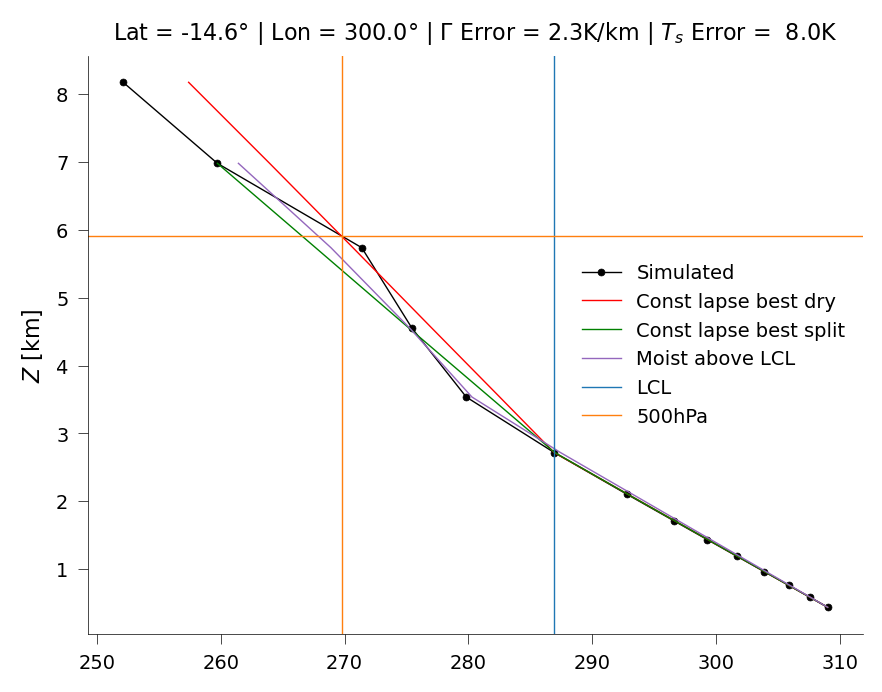

In [363]:
ds_use = ds.isel(co2=0).sel(lat=-15, lon=300, method='nearest')     # Amazon
# ds_use = ds.isel(co2=1).sel(lat=0, lon=25, method='nearest')        # Congo
# ds_use = ds.isel(co2=1).sel(lat=50, lon=25, method='nearest')        # Europe
# ds_use = ds.isel(co2=0).sel(lat=55, lon=290, method='nearest')        # Canada
# ds_use = ds.isel(co2=1).sel(lat=35, lon=100, method='nearest')        # Tibet
ds_use['lapse_above_lcl_Terror'] = ds_use['lapse_above_lcl_error'] * ds_use['lapse_above_lcl_zrange']/1000 * (ds_use.PREFHT/ds_use.p_lcl_emp)**(R*ds_use.lapse_below_lcl/1000/g)

fig, ax = plt.subplots(1, 1)
fig_resize(fig, 5)
ax.plot(ds_use.T.where(ds_use.Z3<ds_use.Z500+3000), ds_use.Z3.where(ds_use.Z3<ds_use.Z500+3000)/1000, marker='o', color='k', label='Simulated')
var = reconstruct_temp(ds_use.T500.isel(plev=0), ds_use.P,
                                            ds_use.p_lcl_emp, float(ds.plev),
                                            ds_use['lapse_below_lcl'] / 1000,
                                            ds_use['lapse_above_lcl'] / 1000)
var = var.where(ds_use.P>=ds_use.p_lcl_emp, reconstruct_temp(ds_use.T500.isel(plev=0), ds_use.P,
                                            ds_use.p_lcl_emp, float(ds.plev),
                                            ds_use['lapse_above_lcl'] / 1000,
                                            ds_use['lapse_above_lcl'] / 1000))
ax.plot(var.where(ds_use.Z3<ds_use.Z500+3000), ds_use.Z3.where(ds_use.Z3<ds_use.Z500+3000)/1000, color='r', label='Const lapse best dry')
var = get_best_lev_split_prof(ds_use.TREFHT, ds_use.PREFHT, ds_use.T, ds_use.P, ds_use.PS, 19, ds_use.hyam, ds_use.hybm, float(ds_use.P0))[0]
ax.plot(var.where(ds_use.Z3<ds_use.Z500+3000), ds_use.Z3.where(ds_use.Z3<ds_use.Z500+3000)/1000, color='g', label='Const lapse best split')
var = apply_func_vec(moist_above_lcl_profile, ds_use.P, ds_use.T_at_lcl_emp, ds_use.p_lcl_emp, ds_use.TREFHT, ds_use.PREFHT)
var = get_moist_above_lcl_prof(ds_use.TREFHT, ds_use.PREFHT, ds_use.T, ds_use.P, 19, ds_use.PS, ds_use.hyam, ds_use.hybm, float(ds_use.P0))[0]
ax.plot(var.where(ds_use.Z3<ds_use.Z500+3000), ds_use.Z3.where(ds_use.Z3<ds_use.Z500+3000)/1000, color='C4', label='Moist above LCL')
ax.axvline(ds_use.T_at_lcl_emp, color='C0', label='LCL')
ax.axvline(ds_use.T500, color='C1', label='500hPa')
ax.axhline(ds_use.Z500/1000, color='C1')
ax.legend()
ax.set_title(f"Lat = {ds_use.lat:.1f}$\degree$ | Lon = {ds_use.lon:.1f}$\degree$ | $\Gamma$ Error = {ds_use.lapse_above_lcl_error.isel(plev=0):.1f}"
             f"K/km | $T_s$ Error =  {ds_use.lapse_above_lcl_Terror.isel(plev=0):.1f}K")
ax.set_ylabel('$Z$ [km]')
plt.show()
# plt.axhline(ds_use.p_lcl_emp)
# plt.axhline(ds_use['lapse_above_lcl_error_p'], color='k')
# plt.gca().invert_yaxis()

In [247]:
def interp_profile_to_z(T: xr.DataArray,
                        Z: xr.DataArray,
                        T_lcl: xr.DataArray,
                        Z_lcl: xr.DataArray,
                        dz: float = 250.0,
                        zmax: float = 10000.0) -> xr.DataArray:
    """Interpolate temperature profiles relative to LCL into z-space.

    Each grid cell has its own model levels and LCL pressure.
    The function interpolates T(z) - T_LCL onto a uniform z grid
    from 0 to zmax above the LCL, in steps of dz.

    Args:
        T (xr.DataArray): Temperature [K], dims ('lat', 'lon', 'lev').
        Z (xr.DataArray): Geopotential height [m], dims ('lat', 'lon', 'lev').
        plev (xr.DataArray): Pressure [hPa], same dims as T and Z.
        p_lcl (xr.DataArray): LCL pressure [hPa], dims ('lat', 'lon').
        dz (float): Vertical spacing [m] for interpolation grid.
        zmax (float): Height above LCL to interpolate up to [m].

    Returns:
        xr.DataArray: Interpolated T - T_LCL,
            dims ('lat', 'lon', 'z_rel') where z_rel is height above LCL [m].
    """
    # Define target relative z-grid
    z_rel = np.arange(0, zmax+dz, dz)

    def _interp_onecell(T_prof, Z_prof, T_lcl, z_lcl):
        # Skip missing
        if np.all(np.isnan(T_prof)):
            return np.full_like(z_rel, np.nan, dtype=float)

        # Shift to relative z grid
        z_target = z_lcl + z_rel
        # print(z_target)
        # print(Z_prof)
        T_target = np.interp(z_target, Z_prof[::-1], T_prof[::-1])
        # print(np.round(Z_prof))
        # print(np.round(z_target))

        return T_target - T_lcl
        # return moist_static_energy(T_target, )

    out = xr.apply_ufunc(
        _interp_onecell,
        T, Z, T_lcl, Z_lcl,
        input_core_dims=[['lev'], ['lev'], [], []],
        output_core_dims=[['z_rel']],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        kwargs={}
    )

    out = out.assign_coords(z_rel=z_rel)
    return out

In [366]:
ds_use = ds.isel(co2=0).sel(lat=slice(-60, 80))
z_lcl_use = interp_var_at_pressure(ds_use.Z3, ds_use.p_lcl_emp, ds_use.PS, ds_use.hyam, ds_use.hybm, ds_use.P0, plev_step=100).Z3.load()
T_lcl_use = interp_var_at_pressure(ds_use.T, ds_use.p_lcl_emp, ds_use.PS, ds_use.hyam, ds_use.hybm, ds_use.P0, plev_step=100)
p_lcl_use = T_lcl_use.plev.load()
T_lcl_use = T_lcl_use.T.load()
# p_lcl_flat = xr.DataArray(ds_use.p_lcl_emp, coords={'lat':ds_use.lat,'lon':ds_use.lon}).stack(points=('lat','lon')).values
var = interp_profile_to_z(ds_use.T, ds_use.Z3, T_lcl_use, z_lcl_use)

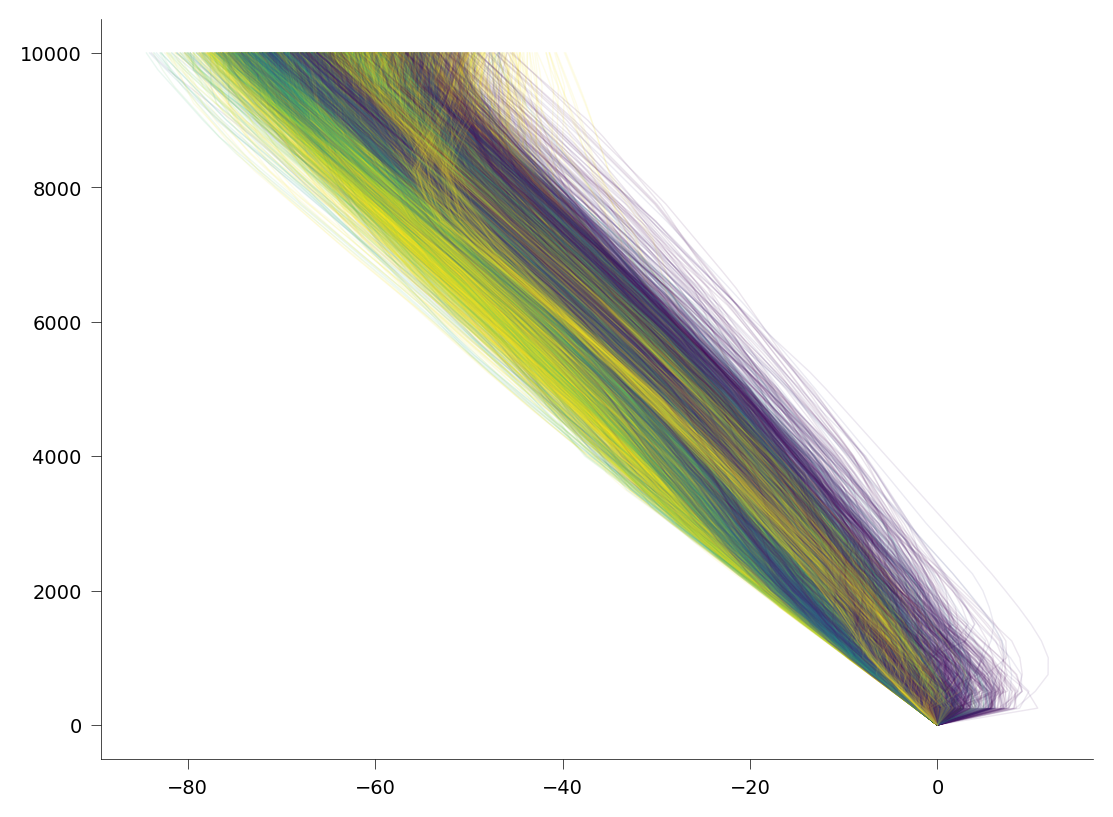

In [264]:
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=100, vmax=2000)

for i in range(ds_use.lat.size):
    for j in range(ds_use.lon.size):
        plt.plot(var.isel(lat=i, lon=j), var.z_rel, alpha=0.1, lw=0.5, c=cmap(norm(z_lcl_use.isel(lat=i, lon=j))))
# plt.plot(var.mean(dim=['lat', 'lon']), var.z_rel, color='k', lw=2)
plt.show()

[0.7894859  0.13339334 0.04878443 0.01388242]


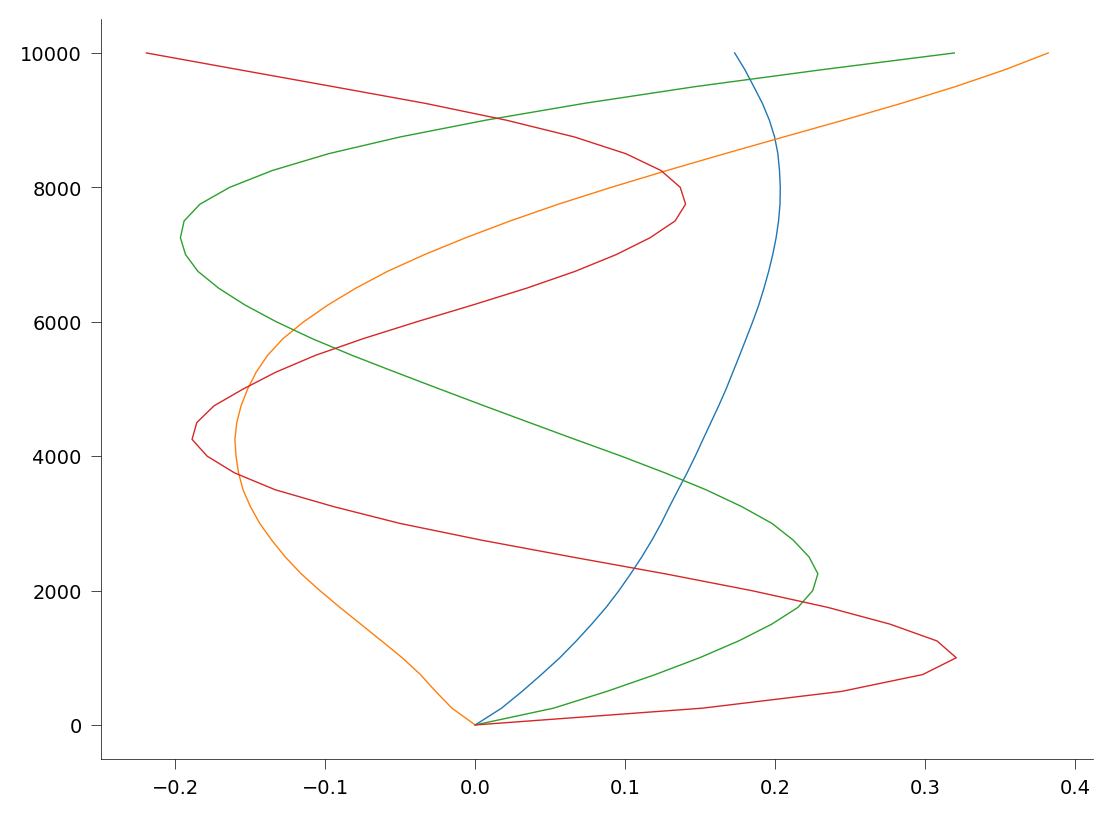

In [368]:
from sklearn.decomposition import PCA

def pca_on_z_profiles(
    profiles: np.ndarray,
    n_modes: int = 6,
    standardize: bool = True
) -> (PCA, np.ndarray, np.ndarray):
    """
    Run PCA on the stacked z profiles (npoints x n_z). Optionally standardize by subtracting mean and
    (optionally) scaling by std across points at each z-level.

    Args:
        profiles: 2D array (npoints, n_z) of T - T_LCL values (K) where rows may contain NaNs for invalid columns.
        n_modes: number of PCA modes to keep.
        standardize: if True, subtract mean profile and scale by stddev (levelwise). If False, subtract mean only.

    Returns:
        pca: trained sklearn PCA object (components_ shape n_modes x n_z).
        scores: 2D array (npoints, n_modes) with NaN rows where input rows had NaN.
        mean_profile: 1D array (n_z,) mean profile used.
        std_profile: 1D array (n_z,) stddev used for scaling (or ones if not standardizing).
    """
    npoints, n_z = profiles.shape
    valid = ~np.any(np.isnan(profiles), axis=1)
    if np.sum(valid) < n_modes + 1:
        raise ValueError("Too few valid columns for PCA; reduce n_modes or check coverage.")

    X_valid = profiles[valid, :]
    mean_profile = X_valid.mean(axis=0)
    Xc = X_valid - mean_profile
    if standardize:
        std_profile = Xc.std(axis=0, ddof=1)
        # avoid zero std
        std_profile[std_profile == 0] = 1.0
        Xc = Xc / std_profile
    else:
        std_profile = np.ones(n_z)

    pca = PCA(n_components=n_modes)
    scores_valid = pca.fit_transform(Xc)  # (n_valid, n_modes)

    scores = np.full((npoints, n_modes), np.nan)
    scores[valid, :] = scores_valid

    return pca, scores, mean_profile, std_profile

var_flat = var.stack(points=('lat','lon')).transpose()
var_flat = var_flat.where(var_flat<99999999999, drop=True)
# pca_on_z_profiles(var_flat, n_modes=2)[0].explained_variance_ratio_
standardize = False
var_out = pca_on_z_profiles(var_flat, n_modes=4, standardize=standardize)
plt.plot(var_out[0].components_[0], var.z_rel)
plt.plot(var_out[0].components_[1], var.z_rel)
plt.plot(var_out[0].components_[2], var.z_rel)
plt.plot(var_out[0].components_[3], var.z_rel)
# plt.plot(2.75*var_out[0].components_[0] + 0.6874*var_out[0].components_[1], var.z_rel)
print(var_out[0].explained_variance_ratio_)

In [355]:
def reconstruct_profile(coeffs: np.ndarray,
                        pca,
                        mean_profile: np.ndarray,
                        std_profile: np.ndarray,
                        standardize: bool = True) -> np.ndarray:
    """Reconstruct absolute temperature profile for one grid point.

    Args:
        coeffs (np.ndarray): Shape (n_modes).
        pca: Fitted sklearn PCA object.
        mean_profile (np.ndarray): Mean profile used in preprocessing (T - T_LCL).
        std_profile (np.ndarray): Std profile (per level), only used if standardize=True.
        T_LCL (float): LCL temperature for this grid point.
        standardize (bool): Whether PCA was done on standardized data.

    Returns:
        np.ndarray: Absolute reconstructed T(z) [K].
    """
    # Step 1: linear combination of PCs
    reconstruction = np.dot(coeffs, pca.components_)  # shape (n_z,)

    # Step 2: undo standardization
    if standardize:
        reconstruction = reconstruction * std_profile + mean_profile
    else:
        reconstruction = reconstruction + mean_profile

    # Step 3: add back absolute T_LCL
    return reconstruction

Text(0.5, 1.0, '[ -1.40415346 -11.92921282   1.27270845  -1.60621672]')

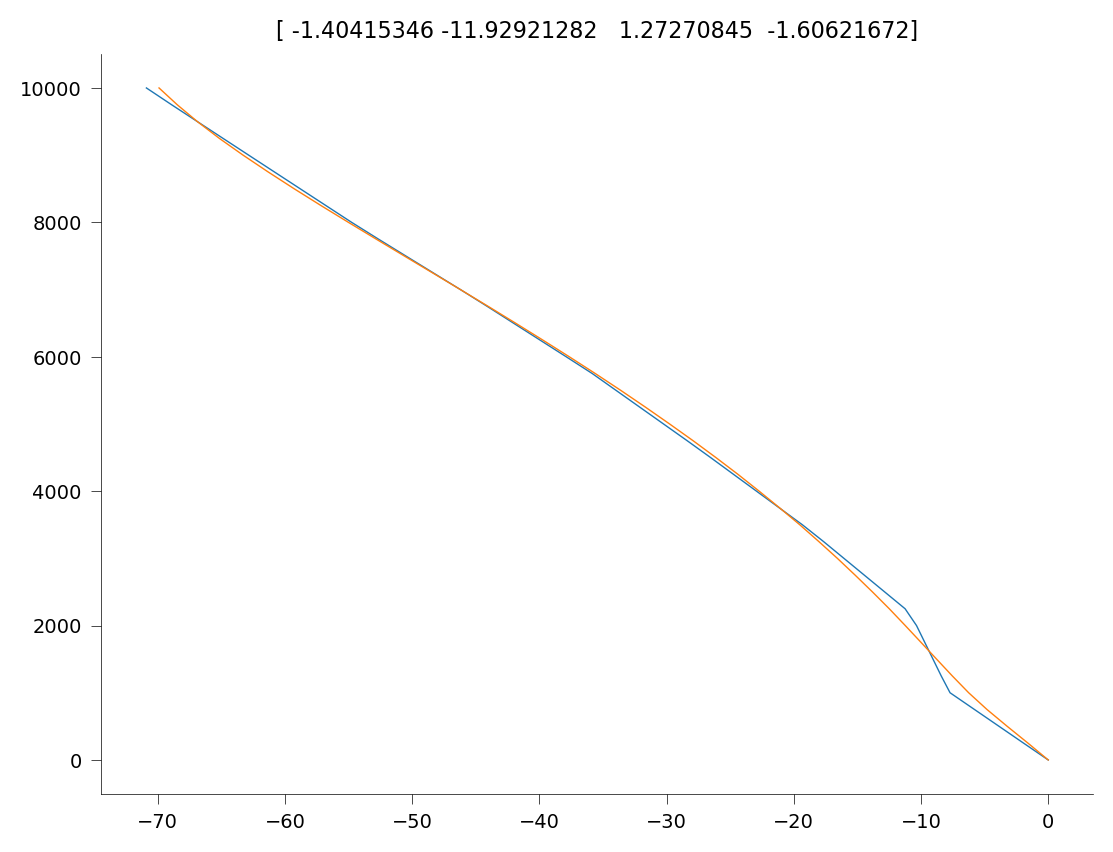

In [375]:
i = 3990
# i = 990

plt.plot(var_flat[i], var.z_rel)
plt.plot(reconstruct_profile(var_out[1][i], var_out[0], var_out[2], var_out[3], standardize=standardize), var.z_rel)
plt.gca().set_title(str(var_out[1][i]))

s## Change in spatial anomaly with warming
Next we take the above plot indicating what is causing the spatial variation in $T_s$ in a given climate, but instead plot the difference between climates.

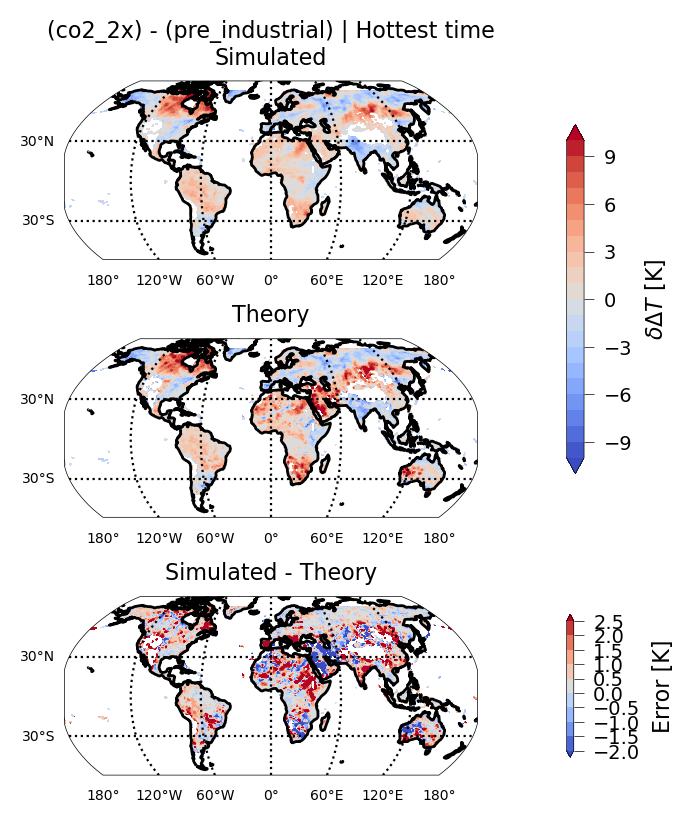

In [19]:
lat_plot_min = -60
lat_plot_max = 80
# norm_by_av = 'FT'
co2_ind = 0
fig = plt.figure(constrained_layout=True, figsize=(10., 4))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max)

levels_use = np.arange(-10, 11, 1)
plot_contour_projection(ax[0], T_breakdown_anom['TREFHT'].isel(co2=1, plev=0) - T_breakdown_anom['TREFHT'].isel(co2=0, plev=0),
                        cmap='coolwarm', levels=levels_use, mask=mask_use.isel(co2=0))
im = plot_contour_projection(ax[1], T_anom_theory.isel(co2=1) - T_anom_theory.isel(co2=0), cmap='coolwarm', levels=levels_use,
                             mask=mask_use.isel(co2=0))
fig.colorbar(shrink=0.8, ax=ax[:2], label='$\delta \Delta T$ [K]', mappable=im)
im = plot_contour_projection(ax[2],
                             T_breakdown_anom['TREFHT'].isel(co2=1, plev=0) - T_breakdown_anom['TREFHT'].isel(co2=0, plev=0) -
                             (T_anom_theory.isel(co2=1) - T_anom_theory.isel(co2=0)),
                             cmap='coolwarm', levels=np.arange(-2, 3, 0.5), mask=mask_use.isel(co2=co2_ind))
# # im = plot_contour_projection(ax[1], var_theory,
# #                              levels=levels_temp_change[norm_by_av],
# #                              cmap='coolwarm' if norm_by_av else 'viridis')
ax[0].set_title(f'({exp_name[1]}) - ({exp_name[0]}) | Hottest time\nSimulated')
ax[1].set_title('Theory')
ax[2].set_title('Simulated - Theory')
fig.colorbar(shrink=0.8, ax=ax[2], label='Error [K]', mappable=im)
# isca_tools.savefig(fig)
plt.show()

#### Contribution to change with warming
Below I plot the mechanisms contributing to the change with warming.

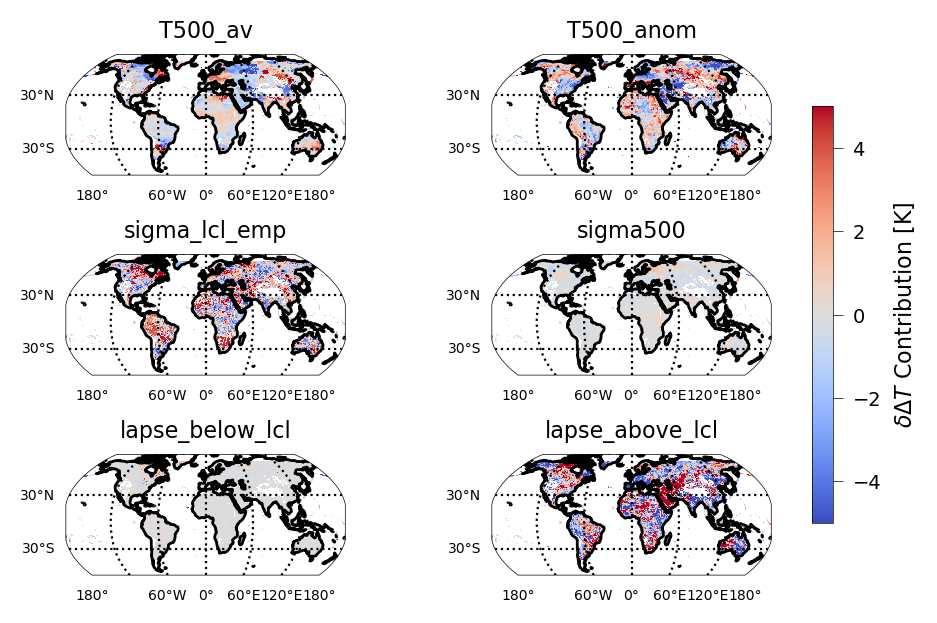

In [20]:
fig = plt.figure(constrained_layout=True,figsize=(10/2,6/2))
ax = fig.subplots(3,2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
ax = ax.flatten()
for i, key in enumerate(T_breakdown_cont):
    initialize_ax_projection(ax[i], lat_min=lat_plot_min, lat_max=lat_plot_max)
    im = ax[i].pcolormesh(ds.lon.values, ds.lat.values, (T_breakdown_cont[key].isel(co2=1, plev=0) -
                                                         T_breakdown_cont[key].isel(co2=0, plev=0)).where(mask_use.isel(co2=co2_ind)),
                        transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-5, vmax=5)
    ax[i].set_title(key.replace('_zonal_daily', '').replace('_resize', ''))
    # im = plot_contour_projection(ax[i], TREFHT_anom_breakdown_cont[key].isel(co2=co2_ind),
    #                              cmap='coolwarm', levels=np.arange(-15, 20, 2.5))
#     fig.colorbar(shrink=0.8, ax=ax[i], label=f'{name_breakdown[key]} [K]', mappable=im)
fig.colorbar(shrink=0.8, ax=ax.ravel(), label=f'$\delta \Delta T$ Contribution [K]', mappable=im)
# fig.suptitle(f'$\Delta T_{"{REFHT}"}$ Breakdown\n{exp_labels[co2_ind]} | $(x={quant[1]}) - (x={quant[0]})$')
plt.show()